In [7]:
# Core libraries
import pandas as pd
import numpy as np

# Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Local project imports
from preprocessing import prepare_data

# Experiment config
ratios = [None, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0]
random_state = 42

# Storage
results = []

In [8]:
# Load datasets
train_df = pd.read_csv("fraudTrain.csv")
test_df = pd.read_csv("fraudTest.csv")

# Basic info
print(f"Train shape: {train_df.shape} | Test shape: {test_df.shape}")
print("Missing values (train):", train_df.isnull().sum().sum())
print("Fraud ratio (train):", train_df["is_fraud"].mean())
print("Fraud ratio (test):", test_df["is_fraud"].mean())

Train shape: (1296675, 23) | Test shape: (555719, 23)
Missing values (train): 0
Fraud ratio (train): 0.005788651743883394
Fraud ratio (test): 0.0038598644278853163


In [9]:
# Fit encoders/scalers once using the full training data
out_train_init = prepare_data(
    train_df,
    mode="linear",
    training=True,
    ratio=0.1,   # small ratio just to initialize encoders/scalers
    fit=True
)

encoders = out_train_init["encoders"]
scalers = out_train_init["scalers"]

# Prepare test data using same encoders/scalers
out_test = prepare_data(
    test_df,
    mode="linear",
    training=False,
    fit=False,
    encoders=encoders,
    scalers=scalers
)
df_test = out_test["df"]

# Split test data
X_test = df_test.drop("is_fraud", axis=1)
y_test = df_test["is_fraud"]

print("Test set shape:", X_test.shape, "| Fraud ratio:", y_test.mean())

Test set shape: (555719, 25) | Fraud ratio: 0.0038598644278853163


In [10]:
for ratio in ratios:
    # Prepare training data for given ratio
    out_train = prepare_data(
        train_df,
        mode="linear",
        training=True,
        ratio=ratio,
        fit=True
    )

    # Extract upsampled and downsampled variants (if they exist)
    for resample_type in ["df_up", "df_down"]:
        if resample_type not in out_train or out_train[resample_type] is None:
            continue  # skip if missing

        df_train = out_train[resample_type]
        X_train = df_train.drop("is_fraud", axis=1)
        y_train = df_train["is_fraud"]

        # Train model
        model = LogisticRegression(
            solver="liblinear",
            class_weight=None,
            random_state=random_state
        )
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)

        # Log results
        results.append({
            "ratio": ratio,
            "resample_type": resample_type.replace("df_", ""),
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "roc_auc": auc
        })

        print(f"[{resample_type}] ratio={ratio} | F1={f1:.4f}, Recall={rec:.4f}, AUC={auc:.4f}")


[df_up] ratio=None | F1=0.1077, Recall=0.0597, AUC=0.8331
[df_down] ratio=None | F1=0.1077, Recall=0.0597, AUC=0.8331
[df_up] ratio=0.05 | F1=0.3779, Recall=0.3646, AUC=0.8361
[df_down] ratio=0.05 | F1=0.3719, Recall=0.3585, AUC=0.8362
[df_up] ratio=0.1 | F1=0.3272, Recall=0.4200, AUC=0.8382
[df_down] ratio=0.1 | F1=0.3251, Recall=0.4200, AUC=0.8372
[df_up] ratio=0.2 | F1=0.2263, Recall=0.4816, AUC=0.8401
[df_down] ratio=0.2 | F1=0.2305, Recall=0.4830, AUC=0.8397
[df_up] ratio=0.3 | F1=0.1828, Recall=0.5580, AUC=0.8421
[df_down] ratio=0.3 | F1=0.1809, Recall=0.5585, AUC=0.8412
[df_up] ratio=0.5 | F1=0.1104, Recall=0.6811, AUC=0.8456
[df_down] ratio=0.5 | F1=0.1136, Recall=0.6844, AUC=0.8444
[df_up] ratio=1.0 | F1=0.0279, Recall=0.7226, AUC=0.8515
[df_down] ratio=1.0 | F1=0.0289, Recall=0.7226, AUC=0.8509


,ratio,resample_type,accuracy,precision,recall,f1,roc_auc
0,0.05,up,0.995366,0.392177,0.364569,0.377869,0.836073
1,0.05,down,0.995327,0.386432,0.358508,0.371947,0.836195
2,0.10,up,0.993333,0.267995,0.420047,0.327220,0.838213
3,0.10,down,0.993268,0.265156,0.420047,0.325095,0.837215
4,0.20,down,0.987549,0.151329,0.482984,0.230453,0.839701
5,0.20,up,0.987289,0.147888,0.481585,0.226287,0.840052
6,0.30,up,0.980738,0.109285,0.558042,0.182776,0.842060
7,0.30,down,0.980479,0.107938,0.558508,0.180912,0.841227
8,0.50,down,0.958785,0.061954,0.684382,0.113622,0.844410
9,0.50,up,0.957642,0.060084,0.681119,0.110427,0.845571


Saved results to results/logreg_results.csv


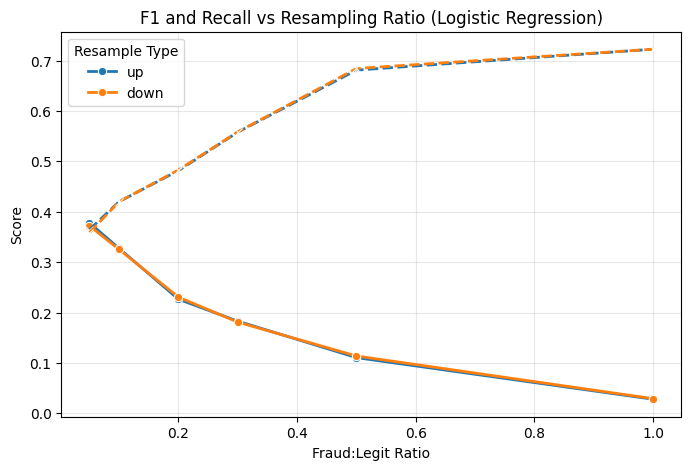

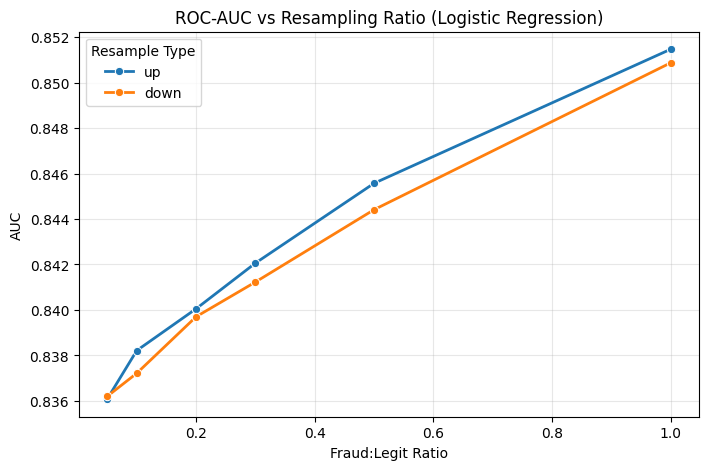

In [14]:
# Convert logged results to DataFrame
results_df = pd.DataFrame(results)

# Sort by F1 descending for quick look
results_df = results_df.sort_values(by="f1", ascending=False).reset_index(drop=True)
display(results_df.head(10))

# Save for report/reference
results_df.to_csv("results/logreg_results.csv", index=False)
print("Saved results to results/logreg_results.csv")

# ---- Plot F1 & Recall vs Ratio ----
plt.figure(figsize=(8,5))

# Plot F1
sns.lineplot(data=results_df, x="ratio", y="f1", hue="resample_type",
             marker="o", linewidth=2, legend="brief")

# Plot Recall on same chart
sns.lineplot(data=results_df, x="ratio", y="recall", hue="resample_type",
             marker="x", linestyle="--", linewidth=2, legend=False)

plt.title("F1 and Recall vs Resampling Ratio (Logistic Regression)")
plt.xlabel("Fraud:Legit Ratio")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.legend(title="Resample Type")
plt.show()

# ---- Plot ROC-AUC vs Ratio ----
plt.figure(figsize=(8,5))
sns.lineplot(data=results_df, x="ratio", y="roc_auc", hue="resample_type",
             marker="o", linewidth=2)
plt.title("ROC-AUC vs Resampling Ratio (Logistic Regression)")
plt.xlabel("Fraud:Legit Ratio")
plt.ylabel("AUC")
plt.grid(True, alpha=0.3)
plt.legend(title="Resample Type")
plt.show()

